# 🧼 2. Load & Clean the Data

 Load Yelp business.json (only take Restaurant Located in Tampa)

In [1]:
import pandas as pd
import json
from tqdm import tqdm

# List untuk menyimpan data restoran di Tampa
tampa_restaurants = []

# Baca file JSON line by line
with open("yelp_academic_dataset_business.json", 'r', encoding='utf-8') as f:
    for line in tqdm(f, desc="Processing Restaurant Data in Tampa"):
        data = json.loads(line)

        # Ambil data bisnis yang berada di Tampa dan memiliki kategori "Restaurant"
        if data.get('city', '').lower() == 'tampa' and data.get('categories'):
            if 'restaurant' in data['categories'].lower():
                tampa_restaurants.append(data)

# Konversi ke DataFrame
df_tampa_restaurants = pd.DataFrame(tampa_restaurants)



# Tampilkan jumlah restoran
print(f"Jumlah restoran di Tampa: {len(df_tampa_restaurants)}")


Processing Restaurant Data in Tampa: 150346it [00:01, 104693.11it/s]

Jumlah restoran di Tampa: 2968


Read the review data and only take the Tampa Restaurant reviews

In [2]:
# Ambil semua business_id dari restaurant Tampa
tampa_restaurant_ids = set(df_tampa_restaurants['business_id'])

matched_reviews = []

with open("yelp_academic_dataset_review.json", 'r', encoding='utf-8') as f:
    for line in tqdm(f, desc="Processing Review Data"):
        review = json.loads(line)
        if review['business_id'] in tampa_restaurant_ids:
            matched_reviews.append(review)

df_reviews_tampa = pd.DataFrame(matched_reviews)

print(f"Total Tampa Restaurant Reviews: {len(df_reviews_tampa)}")


Processing Review Data: 6990280it [00:47, 146803.69it/s]


Total Tampa Restaurant Reviews: 303699


Read the inspection dataset of 'New York Restaurant' and modified to 'Tampa' Restaurant

In [3]:
# Load NYC inspection dataset
df_inspection = pd.read_csv('DOHMH_New_York_City_Restaurant_Inspection_Results_20250730.csv')
df_inspection = df_inspection[['CAMIS', 'DBA', 'BORO', 'BUILDING', 'STREET', 'ZIPCODE', 'CUISINE DESCRIPTION', 'INSPECTION DATE', 'SCORE', 'GRADE']]
df_inspection = df_inspection.dropna(subset=['SCORE', 'GRADE'])  # hanya yang punya nilai
df_inspection = df_inspection[df_inspection['BORO'] != 'Missing']



Buat sample data modifikasi "NYC inspection dataset" jadi data dummy "Tampa inspection dataset" (Nama Mirip antar restaurant, generate random score, grade, boro dll.)

In [4]:
import random
from datetime import datetime, timedelta

# Simulasi modifikasi nama untuk fuzzy match
def make_typo(name):
    variations = [
        name.lower(), name.upper(), name.replace('a', '@'),
        name.replace('e', '3'), name[:len(name)//2], name + ' Inc.',
        name.replace(' ', ''), name.replace('o', '0')
    ]
    return random.choice(variations)

# Daftar kategori masakan untuk randomisasi
cuisine_list = [
    'American', 'Chinese', 'Mexican', 'Italian', 'Japanese', 'Thai', 
    'Indian', 'Mediterranean', 'Cuban', 'Korean', 'Vietnamese', 'Greek', 
    'French', 'Caribbean', 'BBQ', 'Vegan', 'Bakery'
]

# Fungsi untuk menentukan grade dari score
def get_grade(score):
    if score <= 13:
        return 'A'
    elif score <= 27:
        return 'B'
    else:
        return 'C'

# Fungsi random tanggal dalam rentang tertentu
def random_date(start, end):
    delta = end - start
    random_days = random.randint(0, delta.days)
    return (start + timedelta(days=random_days)).strftime('%m/%d/%Y')

# Rentang tanggal inspeksi (2 tahun terakhir)
start_date = datetime(2022, 1, 1)
end_date = datetime(2024, 7, 1)

# Generate data
inspection_sample = pd.DataFrame({
    'CAMIS': [random.randint(10000000, 99999999) for _ in range(len(df_tampa_restaurants))],
    'DBA': df_tampa_restaurants['name'].apply(make_typo),  # fungsi make_typo dari sebelumnya
    'BORO': ['MANHATTAN'] * len(df_tampa_restaurants),
    'BUILDING': [str(random.randint(1, 999)) for _ in range(len(df_tampa_restaurants))],
    'STREET': ['Main Street'] * len(df_tampa_restaurants),  # bisa juga random nanti
    'ZIPCODE': [str(random.choice(range(10001, 10020))) for _ in range(len(df_tampa_restaurants))],
    'CUISINE DESCRIPTION': [random.choice(cuisine_list) for _ in range(len(df_tampa_restaurants))],
    'INSPECTION DATE': [random_date(start_date, end_date) for _ in range(len(df_tampa_restaurants))],
    'SCORE': [random.randint(0, 40) for _ in range(len(df_tampa_restaurants))]
})

# Tentukan grade dari score
inspection_sample['GRADE'] = inspection_sample['SCORE'].apply(get_grade)



# Lihat 5 data contoh
inspection_sample.head()

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,CUISINE DESCRIPTION,INSPECTION DATE,SCORE,GRADE
0,68963488,R0man F0rum,MANHATTAN,339,Main Street,10013,Vegan,02/27/2022,19,B
1,94978469,Joe's,MANHATTAN,850,Main Street,10003,Thai,01/06/2023,4,A
2,31056554,Imp,MANHATTAN,930,Main Street,10007,Vietnamese,05/08/2023,33,C
3,97114622,PDQ TEMPLE TERRACE,MANHATTAN,529,Main Street,10015,Mexican,02/18/2022,37,C
4,34908672,O'BriensIrishPub,MANHATTAN,505,Main Street,10017,Cuban,11/28/2023,14,B


# Join (Merge) the df_tampa_restaurants and df_reviews_tampa based on 'business_id'

In [5]:
# Join df_reviews_tampa dengan df_tampa_restaurants berdasarkan 'business_id'
df_tampa_joined = pd.merge(df_reviews_tampa, df_tampa_restaurants, on='business_id', how='left')

# Tampilkan beberapa baris hasil join
df_tampa_joined.head()


df_tampa_joined.shape


(303699, 22)

In [6]:
inspection_sample.shape

(2968, 10)

# ✅ Step 1: Fuzzy Matching Restaurant Name (df_tampa_joined and inspection_sample)

In [7]:
from rapidfuzz import process, fuzz

# Ambil daftar nama restoran dari Yelp
yelp_names = df_tampa_joined['name'].dropna().unique()

# Buat list hasil match: [(dba_name, matched_name, score), ...]
matches = []
for dba in inspection_sample['DBA']:
    match = process.extractOne(dba, yelp_names, scorer=fuzz.token_sort_ratio)
    if match[1] > 80:  # threshold cocok
        matches.append((dba, match[0], match[1]))

# Masukkan hasil match ke dataframe
df_matches = pd.DataFrame(matches, columns=['DBA', 'matched_name', 'score'])

# Gabungkan ke inspection_sample
inspection_matched = inspection_sample.merge(df_matches, on='DBA', how='inner')


In [8]:
inspection_matched.head()

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,CUISINE DESCRIPTION,INSPECTION DATE,SCORE,GRADE,matched_name,score
0,68963488,R0man F0rum,MANHATTAN,339,Main Street,10013,Vegan,02/27/2022,19,B,Roman Forum,81.818182
1,54884148,L33 Roy S3lmon's,MANHATTAN,491,Main Street,10011,American,02/03/2022,32,C,Lee Roy Selmon's,81.250000
2,54087774,The Silo Eatery Coffee Bakery Inc.,MANHATTAN,508,Main Street,10012,Japanese,10/01/2023,35,C,The Silo Eatery Coffee Bakery,92.063492
3,11880141,MOSI Food Truck Rally,MANHATTAN,111,Main Street,10011,Vegan,05/21/2024,35,C,MOSI Food Truck Rally,100.000000
4,71646778,Big Mike's BBQ,MANHATTAN,607,Main Street,10009,Cuban,02/20/2023,3,A,Big Mike's BBQ,100.000000


In [9]:
inspection_matched.shape

(2575, 12)

# ✅ Step 2: Retrieve Reviews Related to Matched Names

In [10]:
# Gabung dengan df_tampa_joined untuk dapatkan review per restoran
df_final = inspection_matched.merge(
    df_tampa_joined, left_on='matched_name', right_on='name', how='inner'
)

# FYI :
# "DBA": "Doing Business As — the public-facing name of the restaurant."

# Pilih kolom penting (with lat and long)
df_final_lat_long = df_final[['text', 'SCORE', 'GRADE', 'name', 'matched_name', 'DBA', 'latitude', 'longitude']]
df_final_lat_long = df_final_lat_long.dropna(subset=['text', 'SCORE'])


In [11]:
# Gabung dengan df_tampa_joined untuk dapatkan review per restoran
df_final = inspection_matched.merge(
    df_tampa_joined, left_on='matched_name', right_on='name', how='inner'
)

# FYI :
# "DBA": "Doing Business As — the public-facing name of the restaurant."

# Pilih kolom penting
df_final = df_final[['text', 'SCORE', 'GRADE', 'name', 'matched_name', 'DBA']]
df_final = df_final.dropna(subset=['text', 'SCORE'])


In [12]:
df_final.shape

(687790, 6)

In [13]:
df_final_lat_long.head()

,text,SCORE,GRADE,name,matched_name,DBA,latitude,longitude
0,This is right around the corner from our house...,19,B,Roman Forum,Roman Forum,R0man F0rum,28.046203,-82.505053
1,Roman Forum has been open for about a week. 80...,19,B,Roman Forum,Roman Forum,R0man F0rum,28.046203,-82.505053
2,"I guess I should have ordered the Pizza, becau...",19,B,Roman Forum,Roman Forum,R0man F0rum,28.046203,-82.505053
3,Had dinner here last week and I was very impre...,19,B,Roman Forum,Roman Forum,R0man F0rum,28.046203,-82.505053
4,Every single thing we had here was delicious! ...,19,B,Roman Forum,Roman Forum,R0man F0rum,28.046203,-82.505053


In [14]:
df_final.head()

df_final.columns

Index(['text', 'SCORE', 'GRADE', 'name', 'matched_name', 'DBA'], dtype='object')

# 🔁 STEP 1: Add additional review-level 'stars_x' features

In [15]:
# Merge to bring back additional features from df_tampa_joined
df_model = df_final.merge(
    df_tampa_joined[['text', 'stars_x']],  # tambahkan kolom 'text'
    on='text',
    how='left'
)

# Rename for clarity
df_model.rename(columns={'stars_x': 'review_stars'}, inplace=True)

# Optional: drop any remaining nulls in SCORE or text
df_model = df_model.dropna(subset=['SCORE', 'text'])

In [16]:
df_model.head()

,text,SCORE,GRADE,name,matched_name,DBA,review_stars
0,This is right around the corner from our house...,19,B,Roman Forum,Roman Forum,R0man F0rum,4.0
1,Roman Forum has been open for about a week. 80...,19,B,Roman Forum,Roman Forum,R0man F0rum,4.0
2,"I guess I should have ordered the Pizza, becau...",19,B,Roman Forum,Roman Forum,R0man F0rum,1.0
3,Had dinner here last week and I was very impre...,19,B,Roman Forum,Roman Forum,R0man F0rum,5.0
4,Every single thing we had here was delicious! ...,19,B,Roman Forum,Roman Forum,R0man F0rum,5.0


In [17]:
df_model.shape

(691291, 7)

# Dataset sampling

✅ Step 1: Sample a Few Rows per Restaurant
 start by taking a maximum of N reviews per restaurant (say 10):

In [18]:
import pandas as pd

# Sample up to 10 reviews per restaurant
df_temp = (
    df_model.groupby('DBA', group_keys=False)
    .apply(lambda x: x.sample(n=min(10, len(x)), random_state=42))
    .reset_index(drop=True)
)


C:\Users\lenovo\AppData\Local\Temp\ipykernel_23128\3765428973.py:6: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=min(10, len(x)), random_state=42))


In [19]:
df_temp.shape

(15396, 7)

✅ Step 2: Randomly Select 5000 Rows from That Result
from the balanced sample (df_temp), take a random sample of exactly 5000 rows:

In [20]:
# Randomly take 5000 rows from the balanced sample
df_model_sampled = df_temp.sample(n=5000, random_state=42).reset_index(drop=True)
df_model_sampled.shape


(5000, 7)

In [21]:
df_model_sampled.head()

,text,SCORE,GRADE,name,matched_name,DBA,review_stars
0,We have been here many times. Good food at rea...,12,A,Chick-fil-A,Chick-fil-A,Chick-fil-A,3.0
1,Love the food. It is a small but quaint space....,0,A,Thai 5 Fast Food,Thai 5 Fast Food,thai 5 fast food,5.0
2,Love the place. Worth the hour drive and will ...,15,B,Burnz Restaurant Bar & Grill,Burnz Restaurant Bar & Grill,Burnz Rest@ur@nt B@r & Grill,5.0
3,Feb 2018- I must continue to rave about this r...,28,C,The Olde Heights Bistro,The Olde Heights Bistro,the olde heights bistro,5.0
4,Awesome pizza. I have this at least 3 times a ...,36,C,The Corners,The Corners,The Corners,5.0


# Dataset (df_model) preprocessing

## ✅ Step 1: Preprocess the Text

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Text preprocessing: convert to TF-IDF features
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_text = vectorizer.fit_transform(df_model_sampled['text'])


In [23]:
print(df_model_sampled['text'])

0       We have been here many times. Good food at rea...
1       Love the food. It is a small but quaint space....
2       Love the place. Worth the hour drive and will ...
3       Feb 2018- I must continue to rave about this r...
4       Awesome pizza. I have this at least 3 times a ...
                              ...                        
4995    Best Haitian food in tampa !  Will be back\nWe...
4996    Got a small cheesesteak for lunch and a bag of...
4997    Holy! I've purchased a few snacks and lunch it...
4998    This meal was delicious!!!! We ordered a bunch...
4999    Just ok, salty and everything is covered in re...
Name: text, Length: 5000, dtype: object


In [24]:
print(X_text.shape)

(5000, 5000)


In [25]:
print(X_text[:50].toarray())  # Tampilkan 5 dokumen pertama

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [26]:
import numpy as np

# Lihat 5 baris pertama dalam bentuk dense (array penuh)
X_text_dense = X_text[:5].toarray()
print(X_text_dense)


[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.04932982 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


## ✅ Step 2: Prepare Additional Features 
include review_stars as a numeric feature along with the TF-IDF text:

In [27]:
import scipy.sparse as sp

# Combine text features with review_stars as additional numeric feature
import numpy as np
review_stars_array = df_model_sampled['review_stars'].fillna(0).to_numpy().reshape(-1, 1) 

# Concatenate sparse matrix (text) with dense feature (stars)
X = sp.hstack((X_text, review_stars_array))


# ✅ Step 3: Define Target Variable
 predict SCORE (numerical):

In [28]:
y = df_model_sampled['SCORE'] 


# ✅ Step 4: Train-Test Split

In [29]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


# ✅Step 5: Train a Model
Regression (for SCORE):

In [30]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

model = RandomForestRegressor()
model.fit(X_train, y_train)
preds = model.predict(X_test)

mse = mean_squared_error(y_test, preds)
print(f"Mean Squared Error: {mse:.2f}")


Mean Squared Error: 149.99


# Sentiment Analysis for the text Review :

## ✅ Best Option: Use a Pretrained Fine-Tuned DistilBERT Model
You can use the Hugging Face pipeline for this:

In [ ]:
import torch
print(torch.cuda.is_available())  # Harus True
print(torch.cuda.get_device_name(0))  # GPU NVIDIA RTX 3070)


True
NVIDIA GeForce RTX 3070 Laptop GPU


In [32]:
from transformers import pipeline
import torch


# Load sentiment-analysis pipeline with a fine-tuned DistilBERT model
sentiment_pipeline = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")
# Apply sentiment classification
df_model_sampled['bert_sentiment'] = df_model_sampled['text'].apply(lambda x: sentiment_pipeline(x[:512])[0]['label'])

d:\Project-Prep\Predicting Restaurant Health Risks Based on Yelp Reviews and Inspection Scores\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Device set to use cuda:0
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [33]:
df_model_sampled.head()

,text,SCORE,GRADE,name,matched_name,DBA,review_stars,bert_sentiment
0,We have been here many times. Good food at rea...,12,A,Chick-fil-A,Chick-fil-A,Chick-fil-A,3.0,POSITIVE
1,Love the food. It is a small but quaint space....,0,A,Thai 5 Fast Food,Thai 5 Fast Food,thai 5 fast food,5.0,POSITIVE
2,Love the place. Worth the hour drive and will ...,15,B,Burnz Restaurant Bar & Grill,Burnz Restaurant Bar & Grill,Burnz Rest@ur@nt B@r & Grill,5.0,POSITIVE
3,Feb 2018- I must continue to rave about this r...,28,C,The Olde Heights Bistro,The Olde Heights Bistro,the olde heights bistro,5.0,POSITIVE
4,Awesome pizza. I have this at least 3 times a ...,36,C,The Corners,The Corners,The Corners,5.0,POSITIVE


In [35]:
df_model_sampled.to_csv("sentimen_df_model_sampled.csv", index=False)


# 🧠 Smart EDA Goals & Insightful Visualizations

📊 Top 10 Most Positively Reviewed Restaurants

<Axes: title={'center': 'Top 10 Restaurants in Tampa with Most Positive Reviews'}, ylabel='matched_name'>

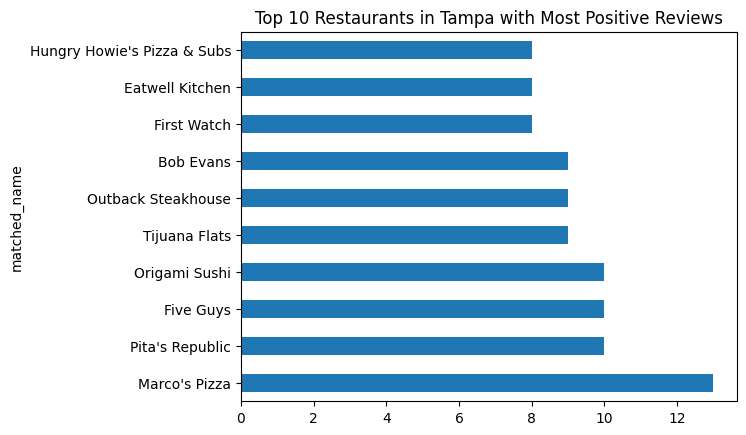

In [38]:
top_positive = (
    df_model_sampled[df_model_sampled['bert_sentiment'] == 'POSITIVE']
    .groupby('matched_name')['text']
    .count()
    .sort_values(ascending=False)
    .head(10)
)

top_positive.plot(kind='barh', title='Top 10 Restaurants in Tampa with Most Positive Reviews')


📊 Top 10 Most Negatively Reviewed Restaurants

<Axes: title={'center': 'Top 10 Restaurants in Tampa with Most Negative Reviews'}, ylabel='matched_name'>

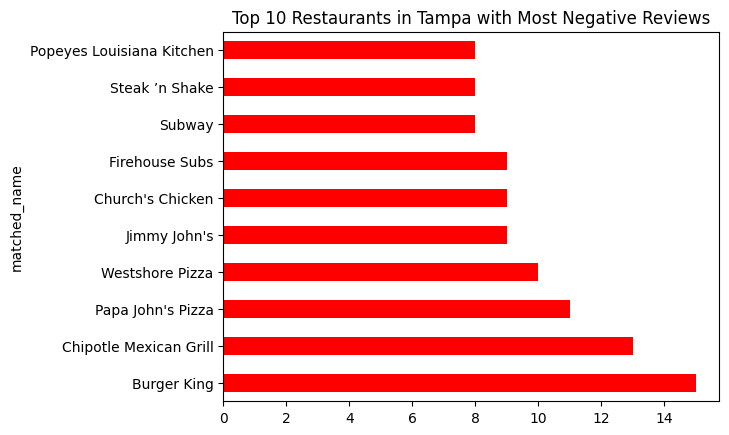

In [39]:
top_negative = (
    df_model_sampled[df_model_sampled['bert_sentiment'] == 'NEGATIVE']
    .groupby('matched_name')['text']
    .count()
    .sort_values(ascending=False)
    .head(10)
)

top_negative.plot(kind='barh', color='red', title='Top 10 Restaurants in Tampa with Most Negative Reviews')


📈 Distribution of Inspection Scores by Sentiment
*in order to see if bad scores correlate with negative reviews

<Axes: xlabel='bert_sentiment', ylabel='SCORE'>

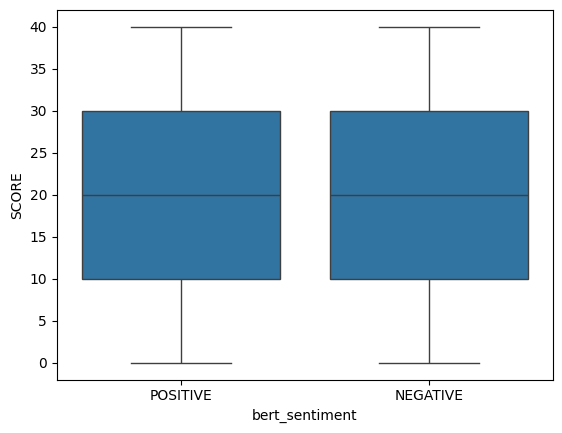

In [40]:
import seaborn as sns
sns.boxplot(x='bert_sentiment', y='SCORE', data=df_model_sampled)


*Through that visualization, we can actually see that the POSITIVE or NEGATIVE sentiment of a review does not correlate with the "Inspection SCORE." As we mentioned earlier, we only created a dummy SCORE for the restaurants in Tampa, Florida, based on the "NYC Restaurant Inspection" dataset. This was done solely to simulate the fuzzy matching between Yelp’s reviews and business dataset with the Restaurant Inspection Data.

⭐ Average Review Stars by Grade

<Axes: title={'center': 'Avg Review Stars by Grade'}, xlabel='GRADE'>

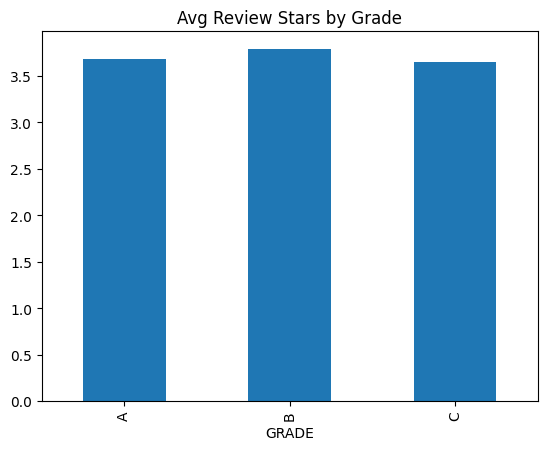

In [41]:
df_model_sampled.groupby('GRADE')['review_stars'].mean().plot(kind='bar', title='Avg Review Stars by Grade')


*This result also does not accurately represent real-world conditions, as the 'GRADE' data was artificially generated (dummy data). Therefore, it does not truly reflect what would happen in an actual scenario.

🟢🔴 Sentiment Distribution Overall

<Axes: title={'center': 'Sentiment Distribution'}, ylabel='count'>

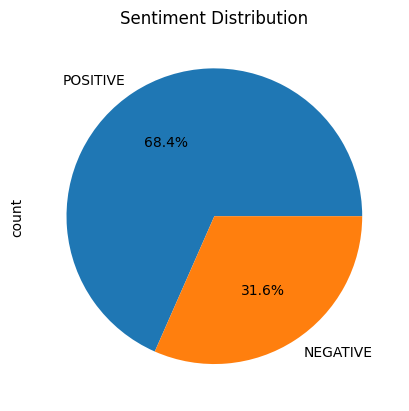

In [42]:
df_model_sampled['bert_sentiment'].value_counts().plot(kind='pie', autopct='%1.1f%%', title='Sentiment Distribution')


🧮 Most Common Words in Positive vs Negative Reviews

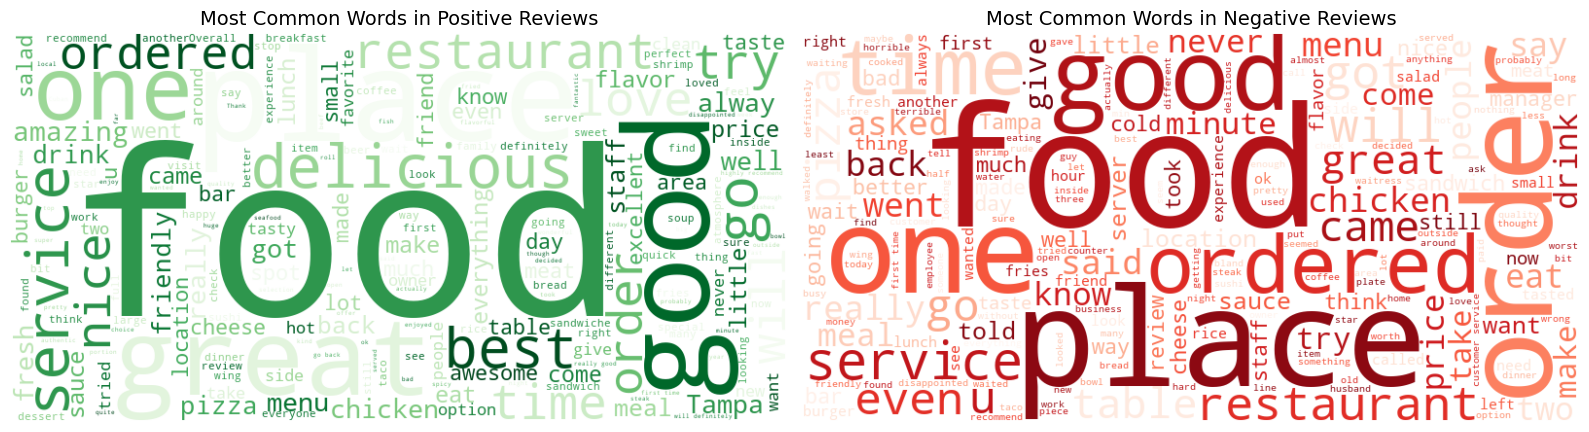

In [43]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# 1. Filter positive and negative reviews
positive_reviews = df_model_sampled[df_model_sampled['bert_sentiment'] == 'POSITIVE']['text']
negative_reviews = df_model_sampled[df_model_sampled['bert_sentiment'] == 'NEGATIVE']['text']

# 2. Gabungkan semua teks menjadi satu string
positive_text = " ".join(positive_reviews.astype(str))
negative_text = " ".join(negative_reviews.astype(str))

# 3. Generate WordClouds
positive_wc = WordCloud(width=800, height=400, background_color='white', colormap='Greens').generate(positive_text)
negative_wc = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(negative_text)

# 4. Tampilkan visualisasi
plt.figure(figsize=(16, 8))

# Positive WordCloud
plt.subplot(1, 2, 1)
plt.imshow(positive_wc, interpolation='bilinear')
plt.axis('off')
plt.title("Most Common Words in Positive Reviews", fontsize=14)

# Negative WordCloud
plt.subplot(1, 2, 2)
plt.imshow(negative_wc, interpolation='bilinear')
plt.axis('off')
plt.title("Most Common Words in Negative Reviews", fontsize=14)

plt.tight_layout()
plt.show()
